In [1]:
# coding: latin-1

import mne
mne.set_log_level('WARNING')

import scipy.io
import numpy as np

mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-22.mat')


In [2]:
# Data point zero for the eight channels.  Should be in V.
signal = mat['data'][0][0][0] * pow(10,6)

print (signal.shape)

ch_names=[ 'Fz'  ,  'Cz',    'P3' ,   'Pz'  ,  'P4'  ,  'PO7'   , 'PO8'   , 'Oz']
ch_types= ['eeg'] * signal.shape[1]

info = mne.create_info(ch_names, 250, ch_types=ch_types)

eeg_mne = mne.io.array.RawArray(signal.T, info)

eeg_mne.plot_psd()

eeg_mne.filter(1,20)

eeg_mne.plot_psd()

(355872, 8)


<ipython-input-2-f37df753e499>:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_mne.plot_psd()
<ipython-input-2-f37df753e499>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  eeg_mne.plot_psd()


<Figure size 640x480 with 1 Axes>

<ipython-input-2-f37df753e499>:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  eeg_mne.plot_psd()
<ipython-input-2-f37df753e499>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  eeg_mne.plot_psd()


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

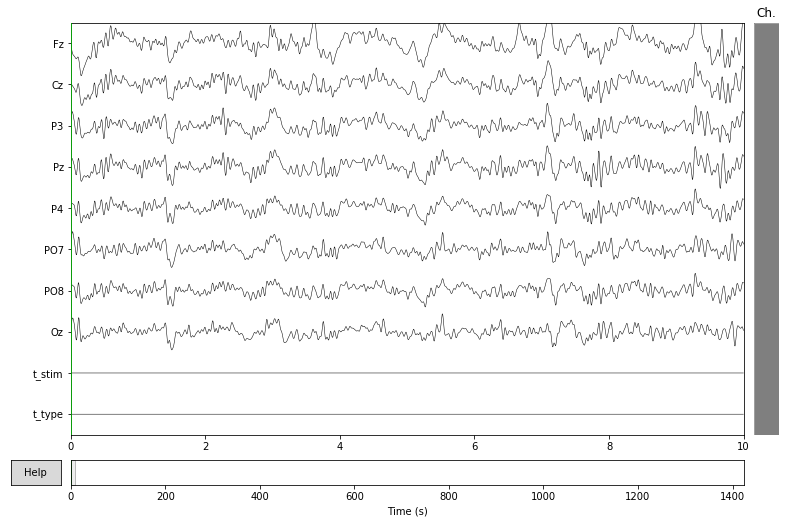

Found 3924 events, first five:
[[7472    0   11]
 [7535    0    4]
 [7599    0   12]
 [7661    0    1]
 [7721    0    8]]


In [3]:
ch_names_events = ch_names + ['t_stim']+ ['t_type']
ch_types_events = ch_types + ['misc'] + ['misc']

t_stim = mat['data'][0][0][2]
t_type = mat['data'][0][0][1]

signal_events = np.concatenate([signal, t_stim, t_type],1)

info_events = mne.create_info(ch_names_events,250, ch_types_events)

eeg_events = mne.io.RawArray(signal_events.T, info_events)

eeg_events.plot(n_channels=10, scalings='auto')

event_times = mne.find_events(eeg_events, stim_channel='t_stim')

print('Found %s events, first five:' % len(event_times))
print(event_times[:5])

In [4]:
event_times = mne.find_events(eeg_events, stim_channel='t_type')

tmin = 0
tmax = 0.8

epochs = mne.Epochs(eeg_mne, event_times, { 'second':2 }, tmin, tmax)


Hits:
Epochs x channels x time
(657, 8, 201)


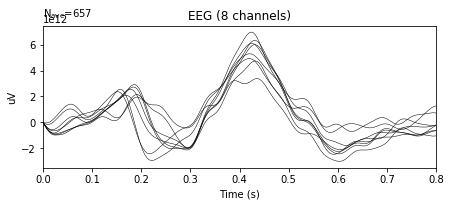

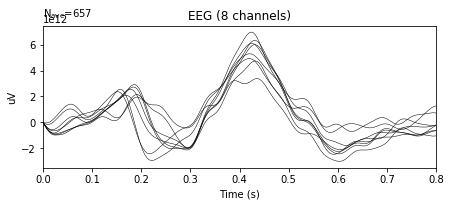

In [5]:
print ('Hits:')
print ('Epochs x channels x time')
print (epochs.get_data().shape)

evoked = epochs.average()
evoked.plot()

In [6]:
event_times = mne.find_events(eeg_events, stim_channel='t_type')

tmin = 0
tmax = 0.8

epochs = mne.Epochs(eeg_mne, event_times, {'first':1}, tmin, tmax)

Nohits:
Epochs x channels x time
(3243, 8, 201)


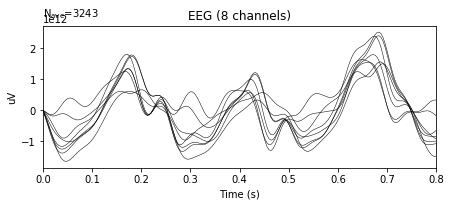

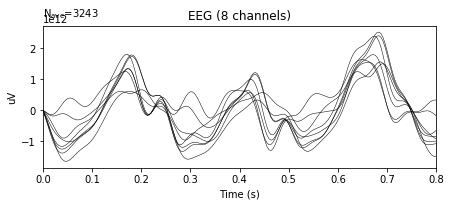

In [7]:
print ('Nohits:')
print ('Epochs x channels x time')
print (epochs.get_data().shape)

evoked = epochs.average()
evoked.plot()

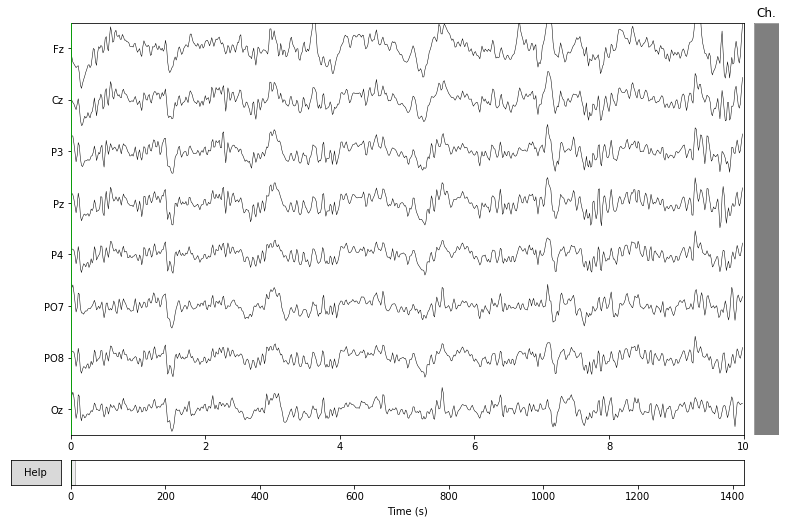

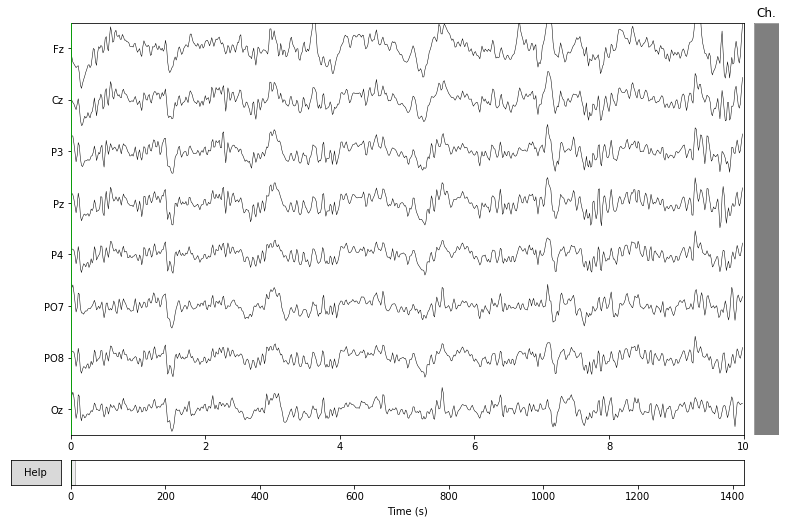

In [8]:
eeg_mne.plot(scalings='auto',n_channels=8,events=event_times)

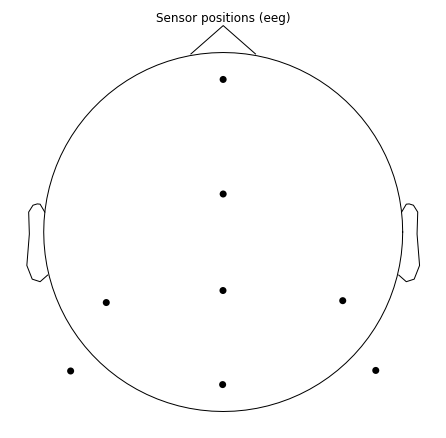

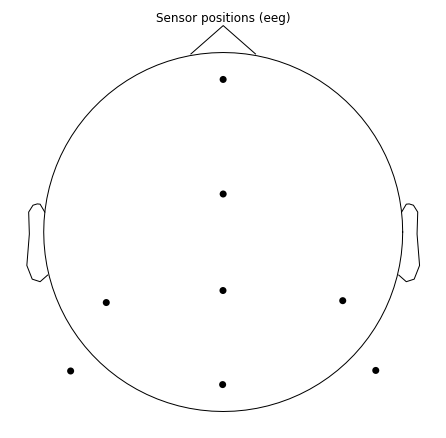

In [9]:
montage = mne.channels.read_montage('standard_1020')

eeg_mne.set_montage(montage)

eeg_mne.plot_sensors()

In [10]:
event_id = { 'first':1, 'second':2 }
#baseline = (0.0, 0.2)
#reject = {'eeg': 70 * pow(10,6)}
reject = None
epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                baseline=None, reject=reject, preload=True,
                verbose=True)

3902 matching events found
No baseline correction applied
Not setting metadata
Loading data for 3902 events and 201 original time points ...
2 bad epochs dropped


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Create classification pipeline
clf = make_pipeline(mne.preprocessing.Xdawn(n_components=3),
                    mne.decoding.Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))

labels = epochs.events[:, -1]
lbls = labels

# Cross validator
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

epochs.resample(20, npad="auto")

print ('Epochs x channels x time')
print (epochs.get_data().shape)

Epochs x channels x time
(3900, 8, 16)


In [12]:
# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs, labels):
    cf=clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

prds = preds

# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))


/anaconda2/envs/mne3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/mne3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/mne3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/mne3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/mne3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

              precision    recall  f1-score   support

       nohit       0.86      0.98      0.92      3243
         hit       0.72      0.24      0.36       657

    accuracy                           0.86      3900
   macro avg       0.79      0.61      0.64      3900
weighted avg       0.84      0.86      0.83      3900

[[3183   60]
 [ 499  158]]


In [13]:
globalavgacc=[]
print ('Averaged classification per trials (20 reps vs 100 reps)')

repetitions=120

for trial in range(0,35):
    epochstrial = epochs[0+repetitions*trial:repetitions*trial+repetitions]

    epochstrial1 = epochstrial['first']
    epochstrial2 = epochstrial['second']

    print ('Epochs x channels x time')
    print (epochstrial.get_data().shape)

    if (trial==0):
        evoked_nohit = epochstrial1.average()
        epochs_data = np.array([evoked_nohit.data])
    else:
        epochs_data = np.concatenate((epochs_data, [epochstrial1.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochstrial2.average().data]), axis=0)


#nave = len(epochs_data)
#evokeds = mne.EvokedArray(evoked_data, info=info, tmin=-0.2,comment='Arbitrary', nave=nave)
labels = np.array([1,2]*35)

print ('Randomize values...')
#labels = np.random.randint(1,3,70)

events = np.array([
[1, 0, 1],
[2, 0, 2],
[3, 0, 1],
[4, 0, 2],
[5, 0, 1],
[6, 0, 2],
[7, 0, 1],
[8, 0, 2],
[9, 0, 1],
[10, 0, 2],
[11, 0, 1],
[12, 0, 2],
[13, 0, 1],
[14, 0, 2],
[15, 0, 1],
[16, 0, 2],
[17, 0, 1],
[18, 0, 2],
[19, 0, 1],
[20, 0, 2],
[21, 0, 1],
[22, 0, 2],
[23, 0, 1],
[24, 0, 2],
[25, 0, 1],
[26, 0, 2],
[27, 0, 1],
[28, 0, 2],
[29, 0, 1],
[30, 0, 2],
[31, 0, 1],
[32, 0, 2],
[33, 0, 1],
[34, 0, 2],
[35, 0, 1],
[36, 0, 2],
[37, 0, 1],
[38, 0, 2],
[39, 0, 1],
[40, 0, 2],
[41, 0, 1],
[42, 0, 2],
[43, 0, 1],
[44, 0, 2],
[45, 0, 1],
[46, 0, 2],
[47, 0, 1],
[48, 0, 2],
[49, 0, 1],
[50, 0, 2],
[51, 0, 1],
[52, 0, 2],
[53, 0, 1],
[54, 0, 2],
[55, 0, 1],
[56, 0, 2],
[57, 0, 1],
[58, 0, 2],
[59, 0, 1],
[60, 0, 2],
[61, 0, 1],
[62, 0, 2],
[63, 0, 1],
[64, 0, 2],
[65, 0, 1],
[66, 0, 2],
[67, 0, 1],
[68, 0, 2],
[69, 0, 1],
[70, 0, 2]
])

events[:,2] = labels

# Cross validator
cv = StratifiedKFold(y=labels, n_folds=10, shuffle=True, random_state=42)

custom_epochs = mne.EpochsArray(epochs_data, info, events, tmin, event_id)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv:
    cf=clf.fit(custom_epochs[train], labels[train])
    preds[test] = clf.predict(custom_epochs[test])


test = range(30,70)
cf = clf.fit(custom_epochs[0:30], labels[0:30])
preds[test] = clf.predict(custom_epochs[test])

preds = preds[test]
labels = labels[test]

# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))

print('Accuracy per trial:'+str(acc))

globalavgacc.append(acc)


Averaged classification per trials (20 reps vs 100 reps)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 8, 16)
Epochs x channels x time
(120, 

KeyError: 'Event "first" is not in Epochs.'

In [ ]:
globalperformance=[]

print 'Averaged classification per row/column'

event_times = mne.find_events(eeg_events, stim_channel='t_stim')
event_id = {'Row1':1,'Row2':2,'Row3':3,'Row4':4,'Row5':5,'Row6':6,'Col1':7,'Col2':8,'Col3':9,'Col4':10,'Col5':11,'Col6':12}

epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                baseline=None, reject=reject, preload=True,
                verbose=True)

repetitions=120

stims = event_times[:,-1]

# Primero tengo que agarrar la lista de labels y asignar a los 420 (35x12)
# el label que le corresponde a cada uno.  Es decir de los primeros 12, 10
# son no hits y 2 hits.
hlbls = []
hpreds = []
for trial in range(0,35):
    r = 0
    c = 0
    for i in range(0,6):
        if (lbls[0+120*trial+i]==2):
            r = stims[0+120*trial+i]
    for i in range(6,12):
        if (lbls[0+120*trial+i]==2):
            c = stims[0+120*trial+i]

    hlbls.append( (r,c) )

classlabels = []
for trial in range(0,35):
    for i in range(0,6):
        if (hlbls[trial][0]==(i+1)):
            classlabels.append(2)
        else:
            classlabels.append(1)
    for i in range(6,12):
        if (hlbls[trial][1]==(i+1)):
            classlabels.append(2)
        else:
            classlabels.append(1)

classlabels = np.array(classlabels)

# Luego necesito calcular los 420 averaging (de repetitions)

# Finalmente aprendo con 180 y me fijo si predigo los 240

# De los 240 adivino 20 letras (de a pares) y con eso calculo la performance

for trial in range(0,35):
    epochstrial = epochs[0+repetitions*trial:repetitions*trial+repetitions]

    epochr1 = epochstrial['Row1']
    epochr2 = epochstrial['Row2']
    epochr3 = epochstrial['Row3']
    epochr4 = epochstrial['Row4']
    epochr5 = epochstrial['Row5']
    epochr6 = epochstrial['Row6']

    epochc1 = epochstrial['Col1']
    epochc2 = epochstrial['Col2']
    epochc3 = epochstrial['Col3']
    epochc4 = epochstrial['Col4']
    epochc5 = epochstrial['Col5']
    epochc6 = epochstrial['Col6']

    evoked = epochr1.average()
    if (trial==0):
        epochs_data = np.array([evoked.data])
    else:
        epochs_data = np.concatenate((epochs_data, [evoked.data]), axis=0)

    epochs_data = np.concatenate((epochs_data, [epochr2.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr3.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr4.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr5.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochr6.average().data]), axis=0)

    epochs_data = np.concatenate((epochs_data, [epochc1.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc2.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc3.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc4.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc5.average().data]), axis=0)
    epochs_data = np.concatenate((epochs_data, [epochc6.average().data]), axis=0)


events=np.array([np.arange(420),np.zeros(420), classlabels])
events = events.T
events = events.astype(int)

event_id = { 'first':1, 'second':2 }
custom_epochs = mne.EpochsArray(epochs_data, info, events, tmin, event_id)

print('Performance Classification of Averaged Epochs')
test = range(180,420)
classpreds = np.empty(len(classlabels))
cf = clf.fit(custom_epochs[0:180], classlabels[0:180])
classpreds[test] = clf.predict(custom_epochs[test])

preds = classpreds[test]
labels = classlabels[test]


# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
acc=(cm[0,0]+cm[1,1])*1.0/(np.sum(cm))

globalperformance.append(acc)
